In [1]:
# Load relevant R packages
inLibraries = list('repr','spdep','raster','rgdal','rgeos')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

Warning message:
"package 'spdep' was built under R version 3.4.2"Warning message:
"package 'sp' was built under R version 3.4.2"Warning message:
"package 'raster' was built under R version 3.4.2"Warning message:
"package 'rgdal' was built under R version 3.4.2"Warning message:
"package 'rgeos' was built under R version 3.4.2"

## Raster Operations

Consider the following scenario - A city would like to locate new tornado warning sirens. However, not every location within the city is equally suitable for siren locations. 

Factors that affect site suitability include: a) slope less than 6 degrees is most preferable, greater than 6 degrees but less than 20 degrees is tolerable, while slope greater than 20 degrees is not desirable; b) the closer from the nearest road the better in terms of establishing a connection to the electrical/telecom grid; c) location in a lake is not desireable; d) location in a river is not desirable and areas close to a river could represent a risk of flooding; e) greater residential population is important.  

To evalute these criteria, you've been given a set of 300m x 300m raster datasets: DEM (bocomo/bocoDEM.tif), population in 2010 raster (bocomo/bocoPop.tif; roads (bocomo/bocoRoads.tif); lakes (bocomo/bocoLakes.tif); rivers (bocomo/bocoRivers.tif). In this application, all of the raster datasets have been properly alligned with one another....there is no need to aggregate, allign, etc.

In [2]:
dem <- raster("datasets/bocomo/bocoDEM.tif", values=TRUE)
pop <- raster("datasets/bocomo/bocoPop.tif", values=TRUE)
roads <- raster("datasets/bocomo/bocoRoads.tif", values=TRUE)
lakes <- raster("datasets/bocomo/bocoLakes.tif", values=TRUE)
rivers <- raster("datasets/bocomo/bocoRivers.tif", values=TRUE)

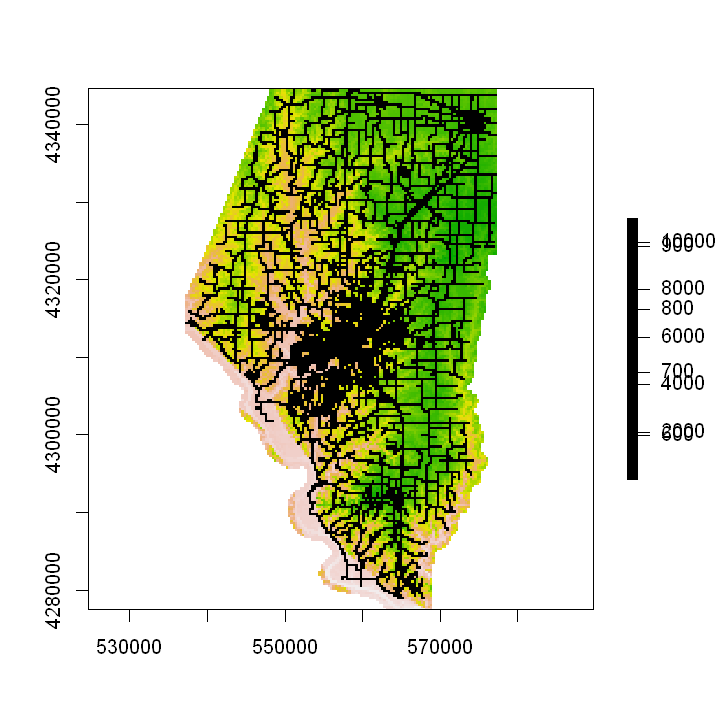

In [3]:
plot(dem, topo.colors)

plot(roads, col = "black", add = TRUE)

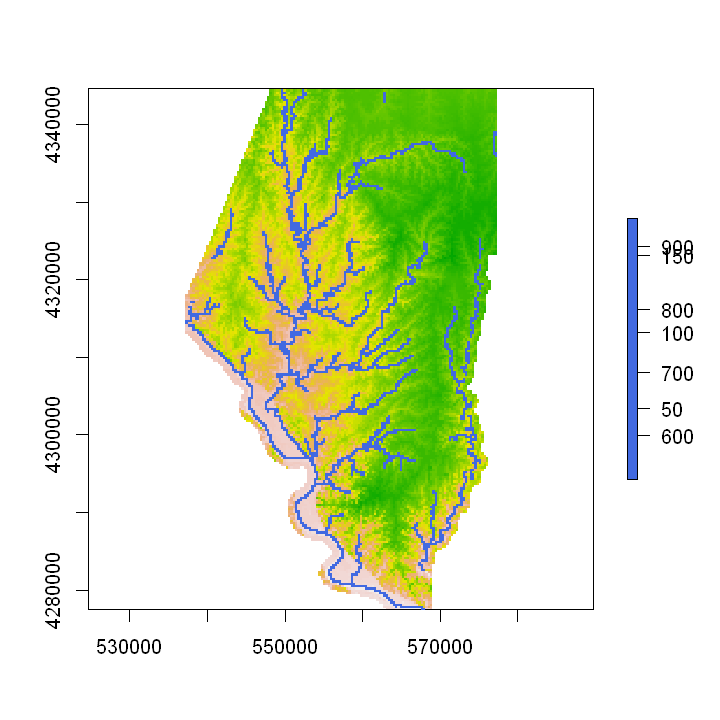

In [4]:
plot(dem, topo.colors)
plot(rivers, col = "royalblue", add = TRUE)

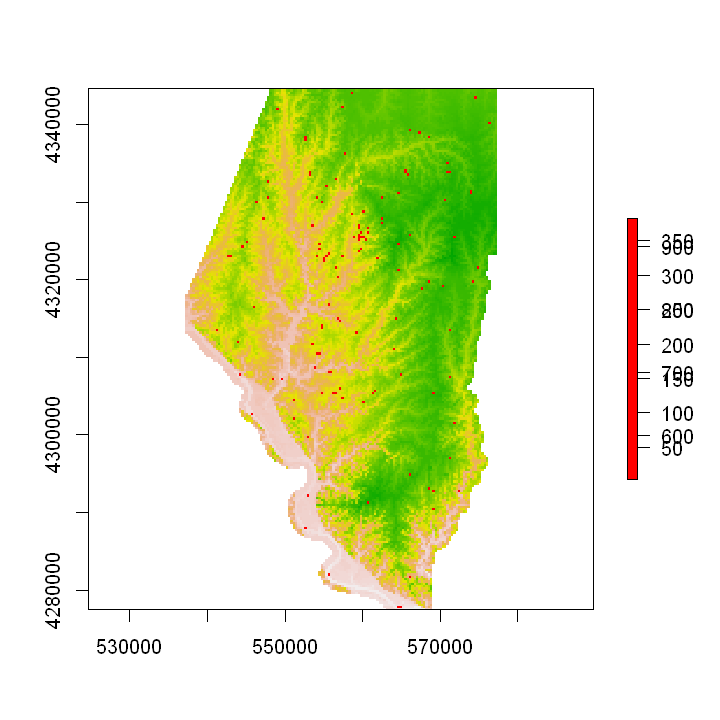

In [5]:
plot(dem, topo.colors)
plot(lakes, col = "red", add = TRUE)

## Process Layers to Generate Analysis Data

Next, process the input layers as needed to generate the analysis data.

Compute a slope raster for the study site. Slope should be reported in degrees and should be based on the Rook's criterion.

In [6]:
slopeDem <- terrain(dem, opt = c("slope"), unit = "degrees", neighbors = 4)
slopeDem

class       : RasterLayer 
dimensions  : 224, 134, 30016  (nrow, ncol, ncell)
resolution  : 300, 300  (x, y)
extent      : 537118.3, 577318.3, 4277445, 4344645  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=utm +zone=15 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0 
data source : in memory
names       : slope 
values      : 0, 29.59195  (min, max)


For every cell, compute it's distance to the nearest road. 

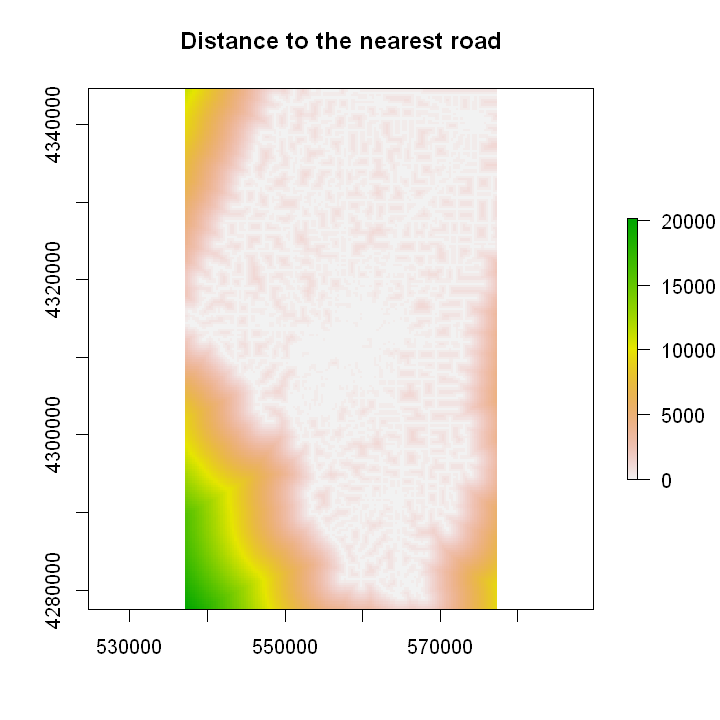

In [7]:
dRoads <- distance(roads)

plot(dRoads, topo.colors, main = "Distance to the nearest road")

 For every cell, compute it's distance to the nearest river.

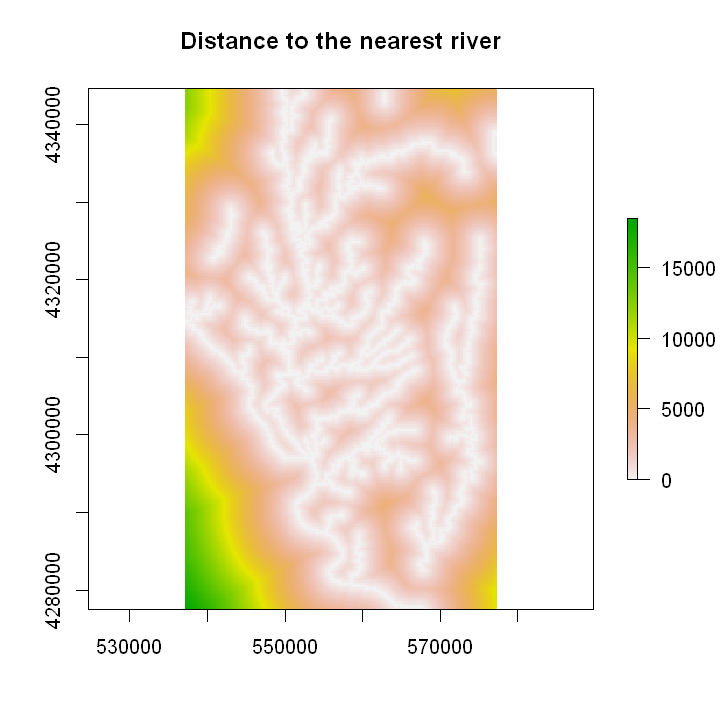

In [8]:
dRiver <- distance(rivers)

plot(dRiver, topo.colors, main = "Distance to the nearest river")

## Translate Data Layers into Relative Utility

Compute utility values for Lakes. In the lakes raster, cells that are lakes have a value, but those that do not are . The reclassify() function won't work for NA values. So, you need to figure out how to create a new raster that has high utility values (=10) for cells with NA and low (=0)for cells that have a lakes value. Be sure to plot the utility values. Bascially, select the values in the raster layer you wish to change and then set those equal to the desired utility value.

In [9]:
lakeUtil <- rivers
lakeUtil[!is.na(lakeUtil)] <- 0
lakeUtil[is.na(lakeUtil)] <- 10

dim(lakeUtil)

[1] 224 134   1

Compute utility for Roads. Reclassify the distance to roads layer such that cells within 1000m [0,1000) have a utility of 10, those >= 1000 and < 1500m have a utility of 8, those >= 1500m and < 2500 have a utility of 7, those >= 2500 and < 3500 have a utility of 5 and those >= 3500 have a utility of 1. Display the conversion table and the utility layer.

In [10]:
roadClasses <- c(
                    0, 1000, 10,
                    1000, 1500, 8,
                    1500, 2500, 7,
                    2500, 3500, 5,
                    3500, 100000, 1
)

roadRcl <- matrix(roadClasses, ncol = 3, byrow = TRUE)
roadRcl

0,1000,10
1000,1500,8
1500,2500,7
2500,3500,5
3500,100000,1


In [11]:
roadUtil <- reclassify(dRoads, roadRcl, right = FALSE)

In [12]:
dim(roadUtil)

[1] 224 134   1

Compute Utility for Slope. Reclassify slope such that cells with slopes greater than 0.0 and less than or equal to 5 degrees (0,5] have a utility of 10, those > 5 and <= 15 have a utility of 5, those > 15 and <= 20 have a utility of 3, those > 20 and <= 35 have a utility of 2 and those > 35 have a utility of 1. Display the conversion table and the utility layer.


In [13]:
slopeClasses <- c(
                    0, 5, 10,
                    5, 15, 5, 
                    15, 20, 3, 
                    20, 35, 2,
                    35, 100000, 1
)

slopeRcl <- matrix(slopeClasses, ncol = 3, byrow = TRUE)
slopeRcl

0,5,10
5,15,5
15,20,3
20,35,2
35,100000,1


In [14]:
slopeUtil <- reclassify(slopeDem, slopeRcl, right = FALSE)

In [15]:
dim(slopeUtil)

[1] 224 134   1

Compute Utility of Rivers.  Reclassify distance from rivers distance = 0.0m has a utility of 0, (0,500m] has a utility of 2, (500m,1000m] utility of 4, (1000m,1500] utility of 5, (1500m,2500] utility of 7, and gerater than 2500m has a utility of 10.  Display the conversion table and the utility layer.


In [16]:
riverClasses <- c(
                    0, 500, 2,
                    500, 1000, 4, 
                    1000, 1500, 5, 
                    1500, 2500, 7,
                    2500, 100000, 10
)

riverRcl <- matrix(riverClasses, ncol = 3, byrow = TRUE)
riverRcl

0,500,2
500,1000,4
1000,1500,5
1500,2500,7
2500,100000,10


In [17]:
riverUtil <- reclassify(dRiver, riverRcl, right = FALSE)
dim(riverUtil)

[1] 224 134   1

Compute Utility for Population. Reclassify population such that those areas with zero population have a utility of 2, (0,35] utility of 4, (35,122] utility of 6, (122,296] utility of 7, (296,640] utility of 8, (640,1500] have a utility of 10. Display the conversion table and the utility layer.

In [18]:
popClasses <- c(
                0, 0, 2,
                0, 35, 4, 
                35, 122, 6, 
                122, 296, 7, 
                296, 640, 8, 
                640, 1500, 10
)

popRcl <- matrix(popClasses, ncol = 3, byrow = TRUE)
popRcl

0,0,2
0,35,4
35,122,6
122,296,7
296,640,8
640,1500,10


In [19]:
popUtil <- reclassify(pop, popRcl, right = FALSE)
dim(popUtil)

[1] 224 134   1

Compute Overall Composite Suitability given the utility layers you have created. Assign weights to each of the five layers and list them below (remember, they should add up to one). Given the utility layers and your weighting scheme, use map algebra to calculate an overall suitability measure. Produce a map of the suitability surface (make sure to include a title that conveys the weighting scheme applied).

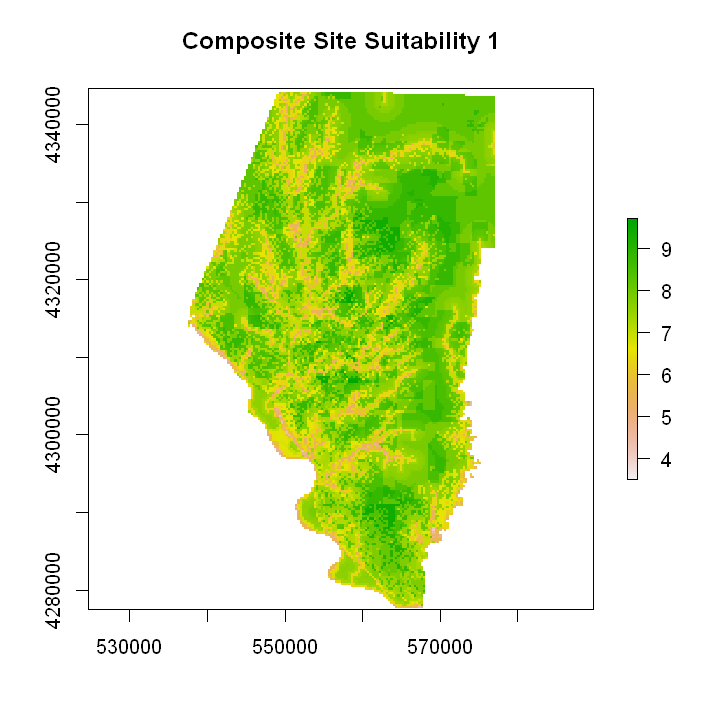

In [20]:
wLake <- 0.1
wRoad <- 0.3
wSlope <- 0.2
wRiver <- 0.1
wPop <- 0.3

compSuit1 <- overlay(lakeUtil, roadUtil, slopeUtil, riverUtil, popUtil, fun = function(a, b, c, d, e){
    return (wLake * a + wRoad * b + wSlope * c + wRiver * d + wPop * e)
})

plot(compSuit1, topo.colors, main = "Composite Site Suitability 1")

Now, consider another weighting scheme and re-compute suitability. Produce a map of the suitability surface

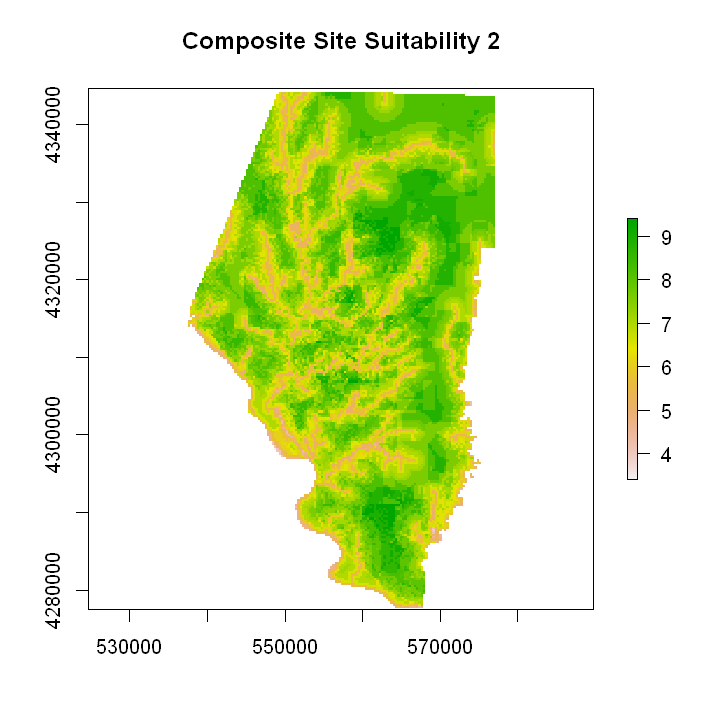

In [21]:
wLake <- 0.1
wRoad <- 0.3
wSlope <- 0.1
wRiver <- 0.2
wPop <- 0.3

compSuit2 <- overlay(lakeUtil, roadUtil, slopeUtil, riverUtil, popUtil, fun = function(a, b, c, d, e){
    return (wLake * a + wRoad * b + wSlope * c + wRiver * d + wPop * e)
})

plot(compSuit2, topo.colors, main = "Composite Site Suitability 2")

By how much and where do the two suitablility layers you created differ?  To evaluate this, compute the absolute difference between composite suitability measure 1 and measure 2. 

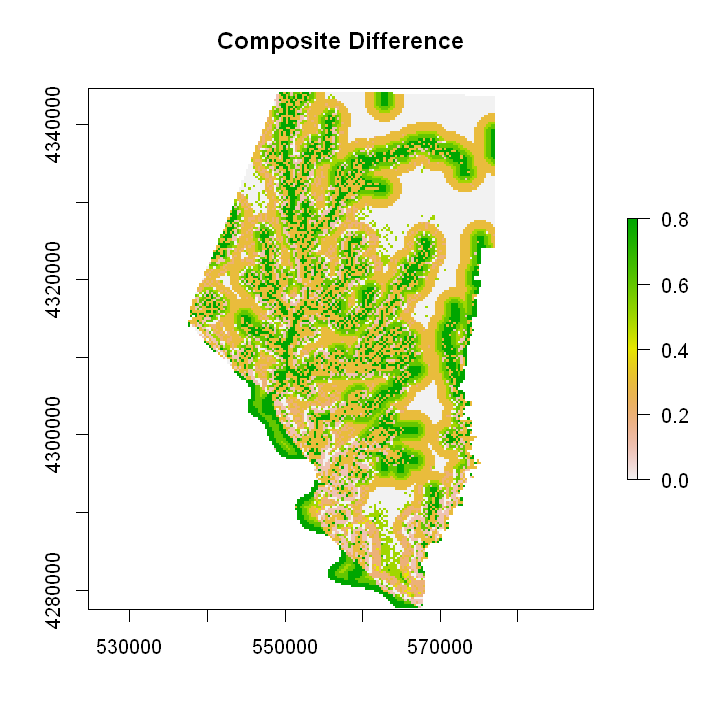

In [22]:
absoluteDiff <- abs(compSuit2 - compSuit1)
plot(absoluteDiff, topo.colors, main = "Composite Difference")